### Experiment Protocols

Subjects rested on a tilt table with foot support and subsequently underwent a series of six changes in posture: 
- Two stand-ups, (= 6 min)
- Two rapid HUTs (75◦ HUT over 2 secs), and (= 6 min)
- Two slow HUTs (75◦ HUT over 50 secs) (= 6 min)
- Each lasting for three minutes and separated by five minutes in the resting supine position.
- The sequence of six interventions was randomized for each subject.
- At the conclusion of the final intervention, the subject was returned to the horizontal position for a final five minutes of   supine baseline recording.

For six postural changes:
- Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest ( atleast 35 + 18 = 53 min of data)

In [1]:
%matplotlib inline
import os
import math

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
#from LaguerreCalc import phi_j, l_j, lagl_j

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

# ECG processing libraries
import scipy.signal 
import peakutils
import heartpy as hp
import wfdb
from wfdb import processing


#### Value of the constants

In [2]:
alpha = .2
J = 8
N1 = 2
N2 = 7
W_n = 90

num_parameters = 10
forgetting_factor = .98

# Values taken from related paper
coeff_S = [39.2343, 10.1963, -5.9242] 
coeff_P = [28.4875, -17.3627, 5.8798, 12.0628, 5.6408, -7.0664, -5.6779, -3.9474]

#### Functions declared

In [3]:
def normalize(x):
    x = x - np.mean(x)
    return x/np.std(x)
    

In [4]:
# define function to identify outliers using Interquartile menthod
def find_outliers(arr, thresh):
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr, 0.75)
    IQR=q3-q1
    outliers = arr [(arr < (q1 - thresh*IQR)) | (arr > (q3 + thresh*IQR))]
    return pd.DataFrame(outliers)

In [5]:
# # define Laguerre polynomial of order j
def phi_j(n, j):
    phi=[]
    sum_= 0
    for i in range(0, j+1):
        sum_ += (-1)**i*math.comb(n,i)*math.comb(j, i)*alpha**(j-i)*(1-alpha)**i
        phi = alpha**((n-j)/2)*(1-alpha)**(1/2)*sum_
    return np.array(phi) #.T

In [6]:
# Define lagerre filter output at time t as a weighted sum of laguerre function and previous RR intervals
phi_mat = np.array([[phi_j(n,j)  for j in range (J+1)] for n in range(W_n)])
def l_j(J, t):  
    l_j_t = [np.sum([phi_mat[n, j]*RR_df_new['int_RR'].values[t-n-1] for n in range(W_n)]) for j in range (J+1)]
    return np.array(l_j_t).T

#### Reag ECG signal of the subject 12726

In [7]:
# Plot the signals, and show the data.
record = wfdb.rdrecord('changes-in-postureData/12726') 
#wfdb.plot_wfdb(record=record, title='Record 12726 from PhysioNet Postural Data', figsize=(12,10)) 
display(record.__dict__)

{'record_name': '12726',
 'n_sig': 3,
 'fs': 250,
 'counter_freq': 24000.0,
 'base_counter': None,
 'sig_len': 825000,
 'base_time': datetime.time(15, 8, 24),
 'base_date': None,
 'comments': ['<age>: 28  <sex>: M  <Height>: 170  <Weight>: 64',
  'Produced by xform from record 12726_orig, beginning at 0:0'],
 'sig_name': ['ABP', 'ECG', 'Angle'],
 'p_signal': array([[ 6.24804749e+01, -1.98291120e+00, -4.57587371e-02],
        [ 6.21055920e+01, -1.98962466e+00, -4.57587371e-02],
        [ 6.14807873e+01, -1.97070491e+00, -4.57587371e-02],
        ...,
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['12726.dat', '12726.dat', '12726.dat'],
 'fmt': ['16', '16', '16'],
 'samps_per_frame': [1, 1, 1],
 'skew': [None, None, None],
 'byte_offset': [None, None, None],
 'adc_gain': [64.02

In [8]:
#Convert record into dataframe whose index is TimedeltaIndex
record_df = record.to_dataframe()
record_df

,ABP,ECG,Angle
0 days 00:00:00,62.480475,-1.982911,-0.045759
0 days 00:00:00.004000,62.105592,-1.989625,-0.045759
0 days 00:00:00.008000,61.480787,-1.970705,-0.045759
0 days 00:00:00.012000,61.168385,-1.966433,-0.045759
0 days 00:00:00.016000,60.855983,-1.979860,-0.045759
...,...,...,...
0 days 00:54:59.980000,0.812246,0.000610,-0.160156
0 days 00:54:59.984000,0.812246,0.000610,-0.160156
0 days 00:54:59.988000,0.812246,0.000610,-0.160156
0 days 00:54:59.992000,0.812246,0.000610,-0.160156


In [9]:
# ECG data is saved in an array
# ecg_data = record.p_signal[:,1]
ecg_df = pd.DataFrame(record_df.iloc[:,1])
angle_df = pd.DataFrame(record_df.iloc[:,2])

#### Working with angle_data

In [10]:
angle_df

,Angle
0 days 00:00:00,-0.045759
0 days 00:00:00.004000,-0.045759
0 days 00:00:00.008000,-0.045759
0 days 00:00:00.012000,-0.045759
0 days 00:00:00.016000,-0.045759
...,...
0 days 00:54:59.980000,-0.160156
0 days 00:54:59.984000,-0.160156
0 days 00:54:59.988000,-0.160156
0 days 00:54:59.992000,-0.160156


#### Finding peaks and rr interval using heartpy

In [11]:
# using heartpy.process, wd = working_data dict in which results are stored, measures(m): measures dict in which results are stored
wd, m = hp.process(ecg_df.ECG, sample_rate = record.fs)

In [12]:
print(m)

{'bpm': 67.542221139381, 'ibi': 888.3332379043802, 'sdnn': 102.32245571956848, 'sdsd': 20.67805513893491, 'rmssd': 31.4129499755703, 'pnn20': 0.4221061792863359, 'pnn50': 0.11778357992457208, 'hr_mad': 84.0, 'sd1': 22.211840468551774, 'sd2': 142.86766621579488, 's': 9969.385017049895, 'sd1/sd2': 0.155471430708484, 'breathingrate': 0.10635075122303364}


In [13]:
wd['peaklist']

[61,
 308,
 560,
 796,
 1042,
 1288,
 1529,
 1775,
 2022,
 2260,
 2508,
 2757,
 2998,
 3248,
 3499,
 3749,
 3988,
 4236,
 4486,
 4725,
 4966,
 5207,
 5449,
 5686,
 5936,
 6188,
 6424,
 6666,
 6909,
 7145,
 7384,
 7630,
 7880,
 8116,
 8365,
 8618,
 8852,
 9086,
 9320,
 9546,
 9784,
 10032,
 10282,
 10533,
 10793,
 11048,
 11304,
 11560,
 11804,
 12055,
 12308,
 12546,
 12792,
 13036,
 13264,
 13502,
 13745,
 13975,
 14221,
 14472,
 14712,
 14959,
 15208,
 15443,
 15685,
 15925,
 16157,
 16401,
 16656,
 16897,
 17148,
 17402,
 17646,
 17888,
 18137,
 18382,
 18625,
 18879,
 19127,
 19366,
 19614,
 19867,
 20109,
 20358,
 20608,
 20848,
 21091,
 21336,
 21568,
 21806,
 22048,
 22283,
 22529,
 22778,
 23014,
 23262,
 23514,
 23749,
 23993,
 24239,
 24475,
 24716,
 24962,
 25200,
 25443,
 25688,
 25924,
 26164,
 26405,
 26637,
 26865,
 27101,
 27337,
 27565,
 27800,
 28037,
 28263,
 28502,
 28743,
 28971,
 29207,
 29447,
 29679,
 29927,
 30170,
 30405,
 30646,
 30888,
 31119,
 31359,
 31599

In [14]:
len(wd['peaklist'])

3800

#### Find rr interval using 'peaklist' from 'wd'

In [15]:
t = np.arange(0, len(ecg_df))/record.fs

# Finding RR interval
RR = np.diff(t[wd["peaklist"]])
type(RR)

numpy.ndarray

In [16]:
print(RR)
print(len(RR))
RR_df = pd.DataFrame(RR, columns=['RR'])
RR_df


[0.988 1.008 0.944 ... 0.996 1.092 0.812]
3799


,RR
0,0.988
1,1.008
2,0.944
3,0.984
4,0.984
...,...
3794,1.020
3795,1.040
3796,0.996
3797,1.092


#### Finding angle value at the peaks

In [17]:
peak_angle = angle_df['Angle'][wd['peaklist']].reset_index().drop(columns=['index'])
print(peak_angle)
print(type(peak_angle))

         Angle
0    -0.045759
1    -0.045759
2    -0.045759
3    -0.045759
4    -0.045759
...        ...
3795  0.068638
3796  0.068638
3797  0.068638
3798  0.068638
3799  0.068638

[3800 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


#### Make RR interval dataframe

In [18]:
time_df = t[wd["peaklist"]]
time_df

RR_df = pd.DataFrame(RR, time_df[1:]).reset_index().rename(columns={'index':'beats', 0:'RR'})
RR_df['angle_peaks'] = peak_angle
RR_df

,beats,RR,angle_peaks
0,1.232,0.988,-0.045759
1,2.240,1.008,-0.045759
2,3.184,0.944,-0.045759
3,4.168,0.984,-0.045759
4,5.152,0.984,-0.045759
...,...,...,...
3794,3247.488,1.020,0.068638
3795,3248.528,1.040,0.068638
3796,3249.524,0.996,0.068638
3797,3250.616,1.092,0.068638


In [19]:
print('max RR interval is:', max(RR_df['RR']))
print('min RR interval is:', min(RR_df['RR']))

max RR interval is: 7.727999999999952
min RR interval is: 0.0039999999999054126


(array([9.880e+02, 2.787e+03, 2.000e+01, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.0000e-03, 7.7640e-01, 1.5488e+00, 2.3212e+00, 3.0936e+00,
        3.8660e+00, 4.6384e+00, 5.4108e+00, 6.1832e+00, 6.9556e+00,
        7.7280e+00]),
 <BarContainer object of 10 artists>)

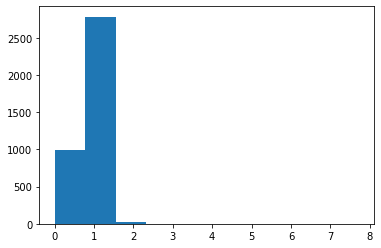

In [20]:
plt.hist(RR_df['RR'])


## Resampling each segment of posture change

In [21]:
peaks,  props= find_peaks(np.round(RR_df['angle_peaks']), width=3, height=[73,76], plateau_size = 3)
props

{'plateau_sizes': array([245, 245, 228, 188], dtype=int64),
 'left_edges': array([ 422, 1099, 2921, 3430], dtype=int64),
 'right_edges': array([ 666, 1343, 3148, 3617], dtype=int64),
 'peak_heights': array([74., 75., 74., 75.]),
 'prominences': array([74., 75., 74., 75.]),
 'left_bases': array([ 365, 1096, 2865, 3427], dtype=int64),
 'right_bases': array([ 724, 1348, 3212, 3622], dtype=int64),
 'widths': array([296.        , 247.50551783, 283.        , 190.19447674]),
 'width_heights': array([37. , 37.5, 37. , 37.5]),
 'left_ips': array([ 396.        , 1097.11290323, 2895.        , 3428.2125    ]),
 'right_ips': array([ 692.        , 1344.61842105, 3178.        , 3618.40697674])}

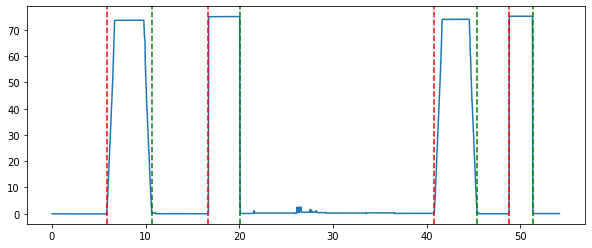

In [22]:
fig, ax = plt.subplots(1,1,figsize = (10,4))

ax.plot(RR_df['beats']/60, RR_df['angle_peaks'])
for i,j in zip(props['left_bases'], props['right_bases']):
    ax.axvline(x=RR_df['beats'][i]/60, color='red', ls='--')
    ax.axvline(x=RR_df['beats'][j]/60, color='green', linestyle='--') 

#### Segmenting the data based on inflexion point

In [23]:
rest1 = RR_df.iloc[:366, :]
slant1 = RR_df.iloc[366:725, :]
rest2 = RR_df.iloc[724:1097, :]
vpeak1 = RR_df.iloc[1096:1349, :]#.reset_index().drop(columns='index')
# slant2 = RR_df.iloc[2865:3213, :]
# rest3 = RR_df.iloc[3212:3428, :]

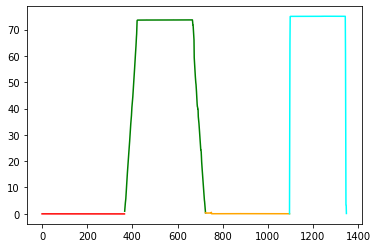

In [24]:
plt.plot(rest1['angle_peaks'], color='red')
plt.plot(slant1['angle_peaks'], color='green')
plt.plot(rest2['angle_peaks'], color='orange')
plt.plot(vpeak1['angle_peaks'], color='cyan')
# plt.plot(slant2['angle_peaks'], color='red')
# plt.plot(rest3['angle_peaks'], color='blue')


In [25]:
slant1['beats']

366    351.436
367    352.412
368    353.408
369    354.388
370    355.320
        ...   
720    634.916
721    635.804
722    636.716
723    637.664
724    638.576
Name: beats, Length: 359, dtype: float64

In [26]:
slant1 = slant1.reset_index().drop(columns='index')
rest2 = rest2.reset_index().drop(columns='index')
vpeak1 = vpeak1.reset_index().drop(columns='index')

In [27]:
slant1['beats'].iloc[-1]

638.576

In [28]:
tstep = 1/250
dt_r1 = np.arange(rest1['beats'].iloc[0], rest1['beats'].iloc[-1], tstep)
dt_s1 = np.arange(slant1['beats'].iloc[0], slant1['beats'].iloc[-1]-tstep, tstep)
dt_r2 = np.arange(rest2['beats'].iloc[0], rest2['beats'].iloc[-1]-tstep, tstep)
dt_vp1 = np.arange(vpeak1['beats'].iloc[0], vpeak1['beats'].iloc[-1]-tstep, tstep)


In [29]:
dt_s1

array([351.436, 351.44 , 351.444, ..., 638.56 , 638.564, 638.568])

In [30]:
len(dt_r1)

87306

In [31]:
f1 = interp1d(rest1['beats'], rest1['RR'], kind='nearest')
f2 = interp1d(slant1['beats'], slant1['RR'], kind='nearest')
f3 = interp1d(rest2['beats'], rest2['RR'], kind='nearest')
f4 = interp1d(vpeak1['beats'], vpeak1['RR'], kind='nearest')



interpolated_r1 = pd.DataFrame(f1(dt_r1), dt_r1).reset_index()
interpolated_s1 = pd.DataFrame(f2(dt_s1), dt_s1 ).reset_index()
interpolated_r2 = pd.DataFrame(f3(dt_r2), dt_r2).reset_index()
interpolated_vp1 = pd.DataFrame(f4(dt_vp1), dt_vp1).reset_index()
#interpolated_r1 = pd.DataFrame(interp1d(dt_r1, rest1['beats'], rest1['RR']), dt_r1).reset_index()
# interpolated_s1 = pd.DataFrame(np.interp(dt_s1, slant1['beats'], slant1['RR']), dt_s1).reset_index()
# interpolated_r2 = pd.DataFrame(np.interp(dt_r2, rest2['beats'], rest2['RR'] ), dt_r2).reset_index()
# interpolated_vp1 = pd.DataFrame(np.interp(dt_vp1, vpeak1['beats'], vpeak1['RR'] ), dt_vp1).reset_index()

In [32]:
interpolated_vp1

,index,0
0,1001.872,0.992
1,1001.876,0.992
2,1001.880,0.992
3,1001.884,0.992
4,1001.888,0.992
...,...,...
51129,1206.388,1.520
51130,1206.392,1.520
51131,1206.396,1.520
51132,1206.400,1.520


In [41]:
frames = [interpolated_r1, interpolated_s1, interpolated_r2, interpolated_vp1]
RR_df_new = pd.concat(frames).rename(columns={'index':'int_beats', 0:'int_RR'}).reset_index()
RR_df_new.head()

,index,int_beats,int_RR
0,0,1.232,0.988
1,1,1.236,0.988
2,2,1.240,0.988
3,3,1.244,0.988
4,4,1.248,0.988


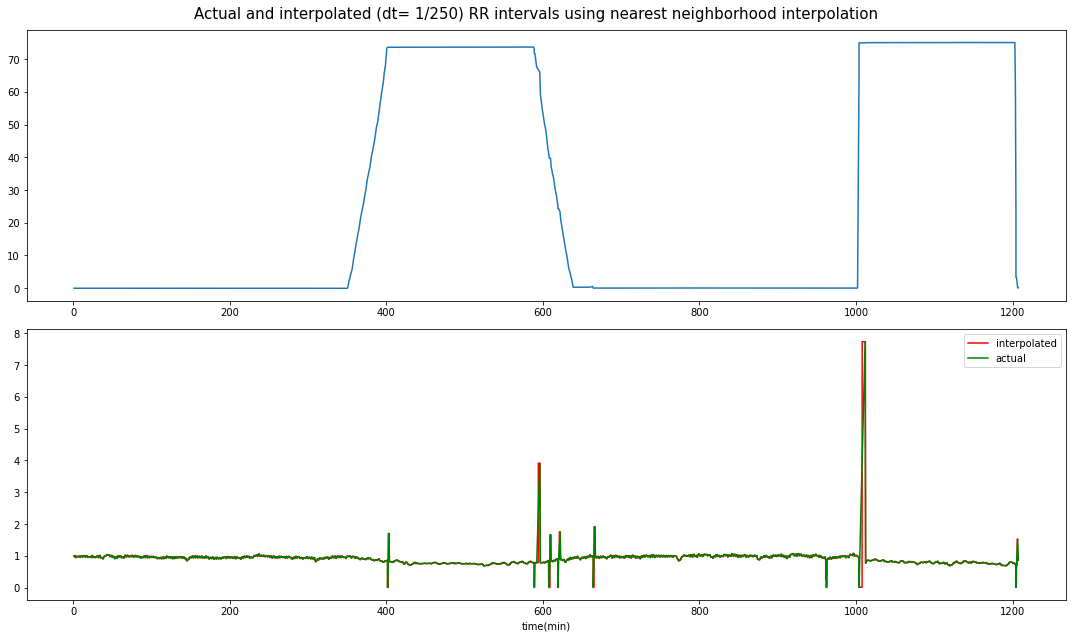

In [34]:
fig, ax = plt.subplots(2,1, figsize=(15,9))
ax[0].plot(RR_df['beats'][:1350], RR_df['angle_peaks'][:1350])
ax[1].plot(RR_df_new['int_beats'], RR_df_new['int_RR'], color='red', label='interpolated')
ax[1].plot(RR_df['beats'][:1350], RR_df['RR'][:1350], color='green', label='actual')
ax[1].legend()
fig.suptitle('Actual and interpolated (dt= 1/250) RR intervals using nearest neighborhood interpolation', fontsize=15)
ax[1].set_xlabel('time(min)')
fig.tight_layout()

#### Calculating Laguerre polynomial of order j with time-lag (RR_intervals) n

In [35]:
phi_mat = np.array([[phi_j(n,j)  for j in range (J+1)] for n in range(W_n)])

In [36]:
phi_mat.shape

(90, 9)

In [37]:
phi_j(0,6)

array(0.00715542)

#### Calculating Laguerre filter output using laguerre polynomials and RR interval at time t in the given window (w_n)

In [38]:
lagl_j = [l_j(J,t) for t in range(W_n, len(RR_df_new)+1)]

In [42]:
G = [f'l{j}'  for j in range(J+1)]
lag_df = pd.DataFrame(lagl_j, columns=G)
lag_df['RR'] = RR_df_new['int_RR']

In [43]:
lag_df.insert(0,'const', 1 )
#lag_df

In [44]:
lag_df.iloc[1,:-1]

const    1.000000
l0       1.598618
l1      -1.598618
l2       1.598618
l3      -1.598618
l4       1.598618
l5      -1.598618
l6       1.598618
l7      -1.598618
l8       1.598618
Name: 1, dtype: float64

In [45]:
lag_df

,const,l0,l1,l2,l3,l4,l5,l6,l7,l8,RR
0,1,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,0.988
1,1,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,0.988
2,1,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,0.988
3,1,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,0.988
4,1,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,-1.598618,1.598618,0.988
...,...,...,...,...,...,...,...,...,...,...,...
300953,1,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,1.520
300954,1,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,1.520
300955,1,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,1.520
300956,1,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,-2.459412,2.459412,1.520


## Recursive Least Square Method implementation

In [46]:
# Initialization
theta = np.zeros((J+1,1))
phi = np.empty((1,J+1))
P = np.eye((J+1))*100

In [51]:
x = np.array([lag_df.iloc[i,:-1] for i in range(len(lag_df))])
x.shape

(300958, 10)

In [52]:
x[0]

array([ 1.        ,  1.59861758, -1.59861758,  1.59861758, -1.59861758,
        1.59861758, -1.59861758,  1.59861758, -1.59861758,  1.59861758])

In [53]:
y = lag_df['RR']
y.shape

(300958,)

## Calculate the indices with forgetting factor .98

In [54]:
# Implementing RLS algorithm
class RecursiveLeastSquares:
    def __init__(self, num_parameters, forgetting_factor):
        self.num_parameters = num_parameters
        self.forgetting_factor = forgetting_factor
        self.theta = np.zeros((num_parameters,1))
        self.P = np.eye(num_parameters)  # Initial covariance matrix

    def update_params(self, x, y):
        x = np.reshape(x, (self.num_parameters, 1))  # Reshape input vector
        y_hat = np.dot(np.transpose(self.theta), x)  # Predicted output


        # Calculate the gain matrix
        k = np.dot(self.P, x) / (self.forgetting_factor + np.dot(np.dot(np.transpose(x), self.P), x))

        # Update the estimated parameter 
        self.theta = self.theta + np.dot(k, (y - y_hat))

        # Update the covariance matrix
        self.P = (1 / self.forgetting_factor) * (self.P - np.dot(np.dot(k, np.transpose(x)), self.P))

    def get_parameters(self):
        return self.theta

## RLS method without windows..... (y=mu_rr)

In [55]:
# Create an instance of the RLS estimator
rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
params_w_n = []

# Perform parameter estimation
for i in range(len(lag_df)):
#     rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
    rls_estimator.update_params(x[i], y[i])
    params_w_n.append(rls_estimator.get_parameters())
    
    #print(rls_estimator.get_parameters()) #Get the estimated parameters

 #### Parameters without using windows method for mu_rr

In [56]:
#reduce the dimension of list elements
params_w_n=np.squeeze(params_w_n)
params_w_n

array([[ 0.03955132,  0.06322743, -0.06322743, ...,  0.06322743,
        -0.06322743,  0.06322743],
       [ 0.04035082,  0.06450553, -0.06450553, ...,  0.06450553,
        -0.06450553,  0.06450553],
       [ 0.04062451,  0.06494306, -0.06494306, ...,  0.06494306,
        -0.06494306,  0.06494306],
       ...,
       [ 0.05686968,  0.00992293,  0.00762717, ...,  0.22330637,
         0.48979487,  0.88982215],
       [ 0.05538824,  0.00991876,  0.00763294, ...,  0.22383874,
         0.49096294,  0.89194435],
       [ 0.05393853,  0.00991469,  0.00763858, ...,  0.22435971,
         0.49210598,  0.89402108]])

#### visualizing parameters

In [ ]:
# fig, ax = plt.subplots(9,1, figsize=(12,12), sharex=True)
# for j in range(1, 10):
#         ax[j-1].plot(RR_clean.beats[W_n-1:]/60, g1j.iloc[:,j], label=f'g1{j}')
#         ax[j-1].legend()
# # plt.legend()
# # plt.plot(RR_clean['beats'][89:]/60, g1j.iloc[:,1])

In [57]:
print(len(params_w_n))
print(params_w_n.shape)

300958
(300958, 10)


In [58]:
params_w_n

array([[ 0.03955132,  0.06322743, -0.06322743, ...,  0.06322743,
        -0.06322743,  0.06322743],
       [ 0.04035082,  0.06450553, -0.06450553, ...,  0.06450553,
        -0.06450553,  0.06450553],
       [ 0.04062451,  0.06494306, -0.06494306, ...,  0.06494306,
        -0.06494306,  0.06494306],
       ...,
       [ 0.05686968,  0.00992293,  0.00762717, ...,  0.22330637,
         0.48979487,  0.88982215],
       [ 0.05538824,  0.00991876,  0.00763294, ...,  0.22383874,
         0.49096294,  0.89194435],
       [ 0.05393853,  0.00991469,  0.00763858, ...,  0.22435971,
         0.49210598,  0.89402108]])

#### Calculate the indices

In [59]:
SAI = coeff_S[0] + np.sum(coeff_S[1:]*params_w_n[:,1:3], axis=1)
PAI = coeff_P[0] + np.sum(coeff_P[1:]*params_w_n[:,3:], axis=1)

In [60]:
print(len(SAI))
print(SAI[:10])

300958
[40.25355785 40.27416132 40.28121453 40.28477641 40.28692462 40.28836115
 40.28938923 40.29016123 40.29076214 40.29124306]


Text(0.5, 1.0, 'SAI/PAI using mu_rr and without moving window')

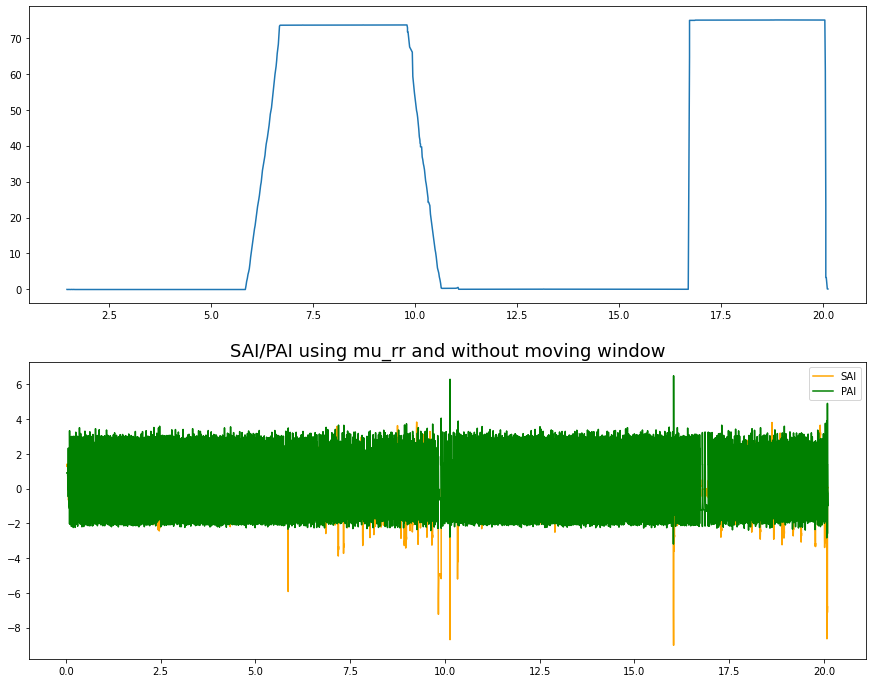

In [61]:
fig, ax = plt.subplots(2,1,figsize = (15,12))

ax[1].plot(RR_df_new['int_beats'][W_n-1:]/60, normalize(SAI), c='orange', label='SAI')
ax[1].plot(RR_df_new['int_beats'][W_n-1:]/60, normalize(PAI), c='green', label='PAI')
ax[1].legend()
ax[0].plot(RR_df['beats'][W_n-1:1350]/60, RR_df['angle_peaks'][W_n-1:1350])
# for i in props['left_bases']:
#     ax[0].axvline(x=RR_df.beats[i]/60, color='red', ls='--')
#     ax[1].axvline(x=RR_df.beats[i]/60, color='red', ls='--')
    
# for i in props['right_bases']:
#     ax[0].axvline(x=RR_df.beats[i]/60, color='green', linestyle='--')  
#     ax[1].axvline(x=RR_df.beats[i]/60, color='green', linestyle='--') 
ax[1].set_title('SAI/PAI using mu_rr and without moving window', fontsize=18)

## RLS method with window of size 90 (y=rr)

In [63]:
# Create an instance of the RLS estimator
rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
params_w2 = []

# Perform recursive parameter estimation
for i in range(W_n, len(lag_df)+1):
    x_w_n = np.array(x[i-W_n:i])
    y_w_n = np.array(y[i-W_n:i])
    [rls_estimator.update_params(x_w_n[j], y_w_n[j]) for j in range(W_n)]
    params_w2.append(rls_estimator.get_parameters())
    #print(rls_estimator.get_parameters()) #Get the estimated parameters

In [64]:
#reduce the dimension of list elements
params_w2=np.squeeze(params_w2)
params_w2

array([[ 0.05643473,  0.06836764, -0.06637549, ...,  0.06186304,
        -0.06232555,  0.0633534 ],
       [ 0.14329699,  0.08302954, -0.07092041, ...,  0.04740168,
        -0.05047719,  0.05684064],
       [ 0.43886105,  0.10151765, -0.06144218, ...,  0.01588135,
        -0.02526096,  0.04564189],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [65]:
SAI2 = coeff_S[0] + np.sum(coeff_S[1:]*params_w2[:,1:3], axis=1)
PAI2 = coeff_P[0] + np.sum(coeff_P[1:]*params_w2[:,3:], axis=1)

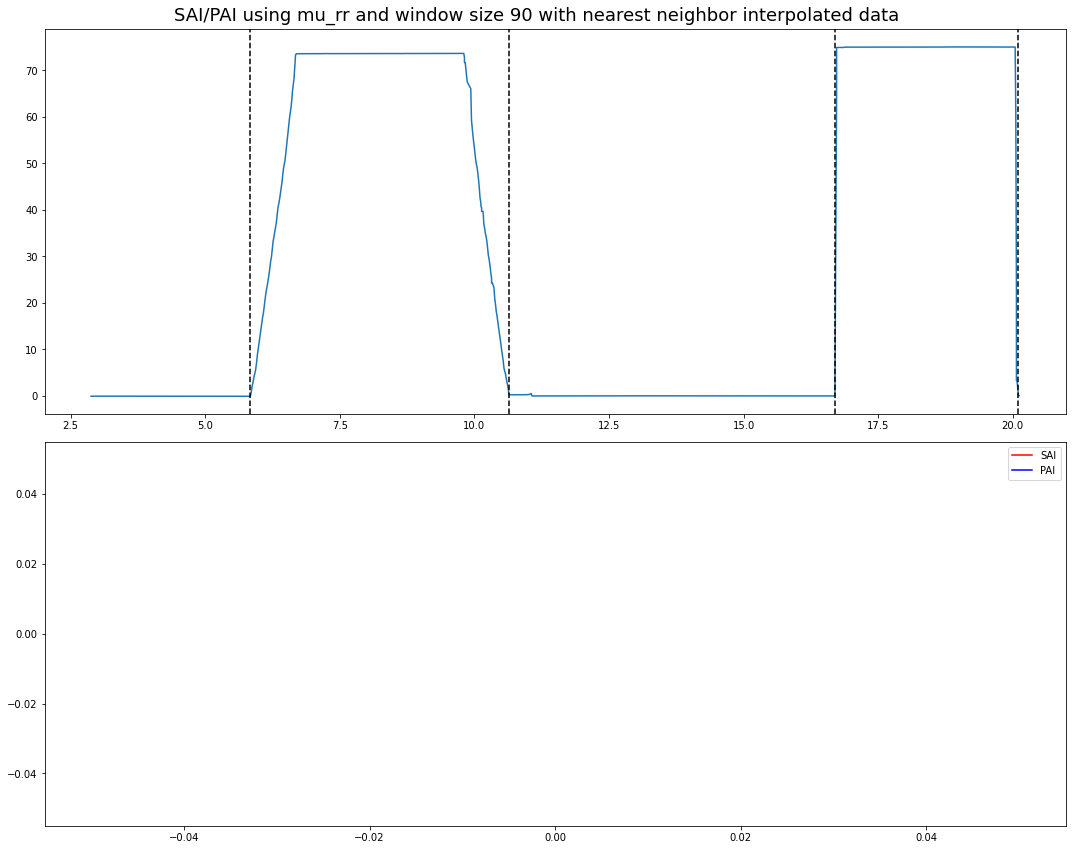

In [66]:
fig, ax = plt.subplots(2,1,figsize = (15,12))

ax[1].plot(RR_df_new['int_beats'][W_n-1:]/60, normalize(SAI2), c='red', label='SAI')
ax[1].plot(RR_df_new['int_beats'][W_n-1:]/60, normalize(PAI2), c='blue', label='PAI')
ax[1].legend()
ax[0].plot(RR_df['beats'][W_n-1:props['right_bases'][1]]/60, RR_df['angle_peaks'][W_n-1:props['right_bases'][1]])
for i in props['left_bases'][:2]:
    ax[0].axvline(x=RR_df.beats[i]/60, color='black', ls='--')
    #ax[1].axvline(x=RR_df.beats[i]/60, color='black', ls='--')
    
for i in props['right_bases'][:2]:
    ax[0].axvline(x=RR_df.beats[i]/60, color='black', linestyle='--')  
    #ax[1].axvline(x=RR_df.beats[i]/60, color='black', linestyle='--') 
fig.suptitle('SAI/PAI using mu_rr and window size 90 with nearest neighbor interpolated data', fontsize=18)
fig.tight_layout()